In [1]:
## DISPLAY ALL nodes and edges, but remove those which are not in the filter (see movies)

    Who are the suppliers and recipients of major conventional weapons?
    What weapons have been exported or imported by specific suppliers or recipients?
    How have the relationships between different suppliers and recipients changed over time?
    Where do countries in conflict get their weapons from?
    How do states implement their export control regulations?
    Where are potentially destabilizing build ups of weapons occurring?
    What is the relationship between access to natural resources and arms transfers?

Ideas for Data dashboard:

Able to select graph and look at data inflow and outflow of each country during that time

In [2]:
import pandas as pd
import numpy as np
import os
import networkx as nx
import operator
import matplotlib.pyplot as plt
import community
%matplotlib inline  
import plotly
from plotly.graph_objs import *
import plotly.plotly as py
import math
import copy


In [3]:
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import ColumnDataSource,HoverTool


# 1) Importing and linking the data

## 1.1) Reading the CSV files into seperate clean panda dataframes

In [4]:
def loadTable(directory, country_code):
    path = directory+'TIV-Import-'+country_code+'-1950-2015.csv'
    df = pd.read_csv(path)
    
    #extract current country
    to_country = df.columns.values.tolist()[0].split('TIV of arms exports to ')[1].split(', 1950-2015')[0]
    
    #downsize
    df = df.ix[9:]
    
    #get rid of column
    df = df.drop(df.columns[[0]],axis =1)
    df.columns = df.iloc[0]
    df.columns.values[0] = 'country'
    df = df.set_index((df['country']))
    df = df.drop(df.columns[0], axis=1)
    
    #take the data less the header row
    df = df[1:] 
    df.index.name = None #credit to ulynn
    df.columns.name = None
    
    # Format of the keys should be YEAR - COUNTRYFROM - COUNTRYTO --> Faster query over the years

    df.columns = df.columns.astype('str').str.replace('\.0','')
        
    df.fillna(0, inplace=True)
    try:
        df.drop(df.loc['Unknown country'].name,inplace=True)
    except:
        ""
        
    #last cleansing
    df.drop(df.index[[-1,-2]],inplace=True)
    df.drop(df.columns[-1], axis=1,inplace=True)

    return df, to_country

## 1.2) Convert one pandas dataframe into a structured dict

In [5]:
#FORMAT
#[YEARS][FROM][TO] = MONEY
def convertTableToDict(df, onecountrydict, countryTo):
    years = list(df.columns.values)
    countries = list(df.index)
    
    for year in years:
        onecountrydict.setdefault(year, dict())
        onecountrydict[year].setdefault(countryTo, dict())
        
        for country in countries:
            value = df.get_value(country, year)
            onecountrydict[year][countryTo].setdefault(country, value)
            
    return onecountrydict

In [6]:
#delete empty cells from dict

def clean_empty(d):
    if not isinstance(d, (dict, list)): #dictionairy or list
        return d
    if isinstance(d, list): 
        return [v for v in (clean_empty(v) for v in d) if v] #list comprehension
    return {k: v for k, v in ((k, clean_empty(v)) for k, v in d.items()) if v}


In [7]:
countryImportDict = dict()
PATH = '/Users/hai/Devproj/weaponstradeanalysis/data/'

countryCodeMap = dict()

for f in os.listdir(PATH):
    if not f.startswith('.'):
        if "country_codes.csv" not in f:
            countryCode = f.replace('TIV-Import-',"").replace('-1950-2015.csv', "")
            df,to_country = loadTable(PATH, countryCode)
            countryImportDict = convertTableToDict(df, countryImportDict, to_country)
            countryCodeMap.setdefault(to_country, countryCode)

countryImportDict = clean_empty(countryImportDict)

MultiDiDict = dict()
for year in countryImportDict:
    MultiDiDict.setdefault(year, dict())
    for countryImport in countryImportDict[year]:
        for countryExport in countryImportDict[year][countryImport]:
            MultiDiDict[year].setdefault(countryExport, dict())
            MultiDiDict[year][countryExport].setdefault(countryImport, 0)
            MultiDiDict[year][countryExport][countryImport] += countryImportDict[year][countryImport][countryExport]

In [8]:
df = pd.DataFrame.from_dict(countryCodeMap, orient="index")
df.sort_index(inplace=True)
df.to_csv('countrymap.csv')

In [9]:
MultiDiDict['2015']['Germany (FRG)']['United States']

200.0

# read weapon expenditure data from SIPRI beta dataset

## Read table into dataframe

In [10]:
militaryexpdf = pd.read_excel('/Users/hai/Devproj/weaponstradeanalysis/newdata/SIPRI extended milex database beta/Constant USD Beta.xlsx')
militaryexpdf = militaryexpdf.iloc[2:175, 2:]
militaryexpdf.columns = militaryexpdf.iloc[0]
militaryexpdf.columns.values[0] = 'Country'
militaryexpdf = militaryexpdf.set_index((militaryexpdf['Country']))
militaryexpdf = militaryexpdf.drop(militaryexpdf.columns[0], axis=1)
militaryexpdf = militaryexpdf[1:] 
militaryexpdf.index.name = None #credit to ulynn
militaryexpdf.columns.name = None
militaryexpdf.drop(['Montenegro'], inplace = True)


namecorrectionmapping = pd.read_csv('/Users/hai/Devproj/weaponstradeanalysis/countrymapping.csv', delimiter = ';', header = None)
namecorrectionmapping.columns = ['countrycode','newname', 'oldname']

namecorrectionmapping.set_index((namecorrectionmapping['oldname']), inplace = True)
namecorrectionmapping.drop(namecorrectionmapping.columns[[0,2]], axis=1, inplace = True)
namecorrectionmapping.index.name = None
namemappingdict = namecorrectionmapping.to_dict()


from decimal import Decimal


def convertmilitaryexpTableToDict(df,namemapping):
    years = list(df.columns.values)
    countries = list(df.index)
    militaryexpdict = dict()
    for year in years:
        militaryexpdict.setdefault(str(year), dict())
        for country in countries:
            value = df.get_value(country, year)
            if isinstance(value,float):
                value = round(Decimal(value * 0.5520917815626),1) #inflation correction from constant 2014 to constant 1990
            militaryexpdict[str(year)].setdefault((namemapping['newname'][country]), value)
    return militaryexpdict

militaryexpdict = convertmilitaryexpTableToDict(militaryexpdf, namemappingdict)

## use the manually created table to synchronize countries

In [11]:
excludedentities = pd.read_csv('excludedcountries.csv', delimiter=';', header = None)
excludedentities.columns = ['Name','Code']
excludedentities.set_index((excludedentities['Name']), inplace = True)
excludedentities.drop(excludedentities.columns[[0]], axis=1, inplace = True)
excludedentities.index.name = None
excludedentities = excludedentities.index


In [12]:
def clean_noncountries(d):
    if not isinstance(d, (dict)): #dictionairy or list
        return d
    return {k: v for k, v in ((k, clean_noncountries(v)) for k, v in d.items()) if k not in excludedentities}

## Analysis function

In [13]:
def createNeighbourGraph(G, node):
    
    newGraph = nx.Graph()
    
    for edge in G.edges(data=True):
        if edge[0] == node or edge[1] == node:
            newGraph.add_edge(edge[0],edge[1],edge[2])
    
    return newGraph

In [14]:
# most fucked up function

def addUpDict(MasterDict):

    SomethingsOverwrittenDict = copy.deepcopy(MasterDict)

    AddedUpDict = dict()

    for year in SomethingsOverwrittenDict:
        AddedUpDict.setdefault(year, dict())
        for countryExport in SomethingsOverwrittenDict[year]:
            for countryImport in SomethingsOverwrittenDict[year][countryExport]:
                AddedUpDict[year].setdefault(countryExport, dict())
                AddedUpDict[year][countryExport].setdefault(countryImport, 0)
                Richtung = SomethingsOverwrittenDict[year][countryExport][countryImport]
                #andere richtung verfügbar?
                if countryImport in SomethingsOverwrittenDict[year]:
                    if countryExport in SomethingsOverwrittenDict[year][countryImport]:
                        andereRichtung = SomethingsOverwrittenDict[year][countryImport][countryExport]
                    else: andereRichtung = 0
                else: andereRichtung = 0
                
                #Transmitting stuff into the AddedUpDict
                if (Richtung + andereRichtung) != 0:
                    AddedUpDict[year][countryExport][countryImport] = Richtung + andereRichtung

                #"Clearing the MasterDict"
                SomethingsOverwrittenDict[year][countryExport][countryImport] = 0

                if countryImport in SomethingsOverwrittenDict[year]:
                    if countryExport in SomethingsOverwrittenDict[year][countryImport]:
                        SomethingsOverwrittenDict[year][countryImport][countryExport] = 0
    
    return AddedUpDict

In [15]:
def createYearGraph(AddedUpDict, year, militaryexpdict):
    
    G = nx.Graph()    
    for countryExport in AddedUpDict[year]:
        for countryImport in AddedUpDict[year][countryExport]:
            if AddedUpDict[year][countryExport][countryImport] != 0:
                G.add_weighted_edges_from([(countryExport,countryImport,AddedUpDict[year][countryExport][countryImport])])
    
    for node in G.nodes_iter():
        if node in militaryexpdict[year]:
            G.node[node]['military expenditure'] = militaryexpdict[year][node]
        else:
            G.node[node]['military expenditure'] = 'no data'
            
    G.graph['year']= year
    
    return G

In [16]:
def createYearMultiDiGraph(AddedUpDict, year ,militaryexpdict):
    
    G = nx.MultiDiGraph()    
    for countryExport in AddedUpDict[year]:
        for countryImport in AddedUpDict[year][countryExport]:
            if AddedUpDict[year][countryExport][countryImport] != 0:
                G.add_weighted_edges_from([(countryExport,countryImport,AddedUpDict[year][countryExport][countryImport])])
    
    for node in G.nodes_iter():
        if node in militaryexpdict[year]:
            G.node[node]['military expenditure'] = militaryexpdict[year][node]
        else:
            G.node[node]['military expenditure'] = 'no data'
            
    G.graph['year']= year
    
    return G

In [17]:
MultiDiDict = clean_empty(clean_noncountries(MultiDiDict))
MultiDiDict = clean_empty(MultiDiDict)
AddedUpDict = addUpDict(MultiDiDict)

year = '1960'

multigraph = createYearMultiDiGraph(MultiDiDict, year ,militaryexpdict)
mastergraph = createYearGraph(AddedUpDict, year , militaryexpdict)

In [18]:
sorted(nx.pagerank_numpy(mastergraph).items(), key=operator.itemgetter(1), reverse=True)[:10]

[('United States', 0.20526553677553744),
 ('Soviet Union', 0.10478705583233927),
 ('United Kingdom', 0.08429183389558412),
 ('Germany (FRG)', 0.06702907888030331),
 ('France', 0.05295981179707184),
 ('China', 0.03559242890220521),
 ('Japan', 0.02651695216565388),
 ('Switzerland', 0.02156040057991938),
 ('India', 0.01978686378117994),
 ('Turkey', 0.018682580022232508)]

In [19]:
from bokeh.charts import Bar, output_notebook, show
output_notebook()

data = pd.DataFrame(sorted(nx.betweenness_centrality(multigraph).items(), key=operator.itemgetter(1), reverse=True)[:10])
data.columns = ['country','betweenness centrality']

p = Bar(data, 'country', values='betweenness centrality', title="betweenness centrality in "+year,color='country', legend=None)

show(p)

Loading BokehJS ...

In [20]:
#nx.draw_networkx(mastergraph, pos = spring_pos, cmap = plt.get_cmap("rainbow"), node_color = bt_colors, node_size = bt_values, with_labels = False)

TIL kmeans is a shitty algorithm, since it only takes X and Y into account, not good for graphs

# Clustering using the louvain method

It uses the louvain method described in Fast unfolding of communities in large networks, Vincent D Blondel, Jean-Loup Guillaume, Renaud Lambiotte, Renaud Lefebvre, Journal of Statistical Mechanics: Theory and Experiment 2008(10), P10008 (12pp)

In [21]:
#first compute the best partition
partition = community.best_partition(mastergraph)

#drawing
size = float(len(set(partition.values())))
pos = nx.spring_layout(mastergraph)
count = 0.

#for com in set(partition.values()) :
    #count = count + 1.
    #list_nodes = [nodes for nodes in partition.keys()
    #                            if partition[nodes] == com]
    #nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 20,
    #                            node_color = str(count / size))
    #nx.draw_networkx_edges(G,pos, alpha=0.5)
#plt.show()

In [22]:
from bokeh.palettes import Spectral10
colormap = Spectral10

In [23]:
pos3=nx.spring_layout(mastergraph, dim=3)

In [24]:
#data=Data(trace1+trace2)
#fig=Figure(data=data, layout=layout)

#py.iplot(fig, filename='Weapontrade')

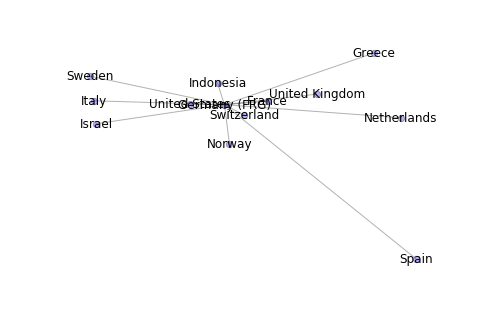

In [25]:
test = createNeighbourGraph(mastergraph, 'Germany (FRG)')
plt.gcf().clear()
nx.draw(test,node_size=40, alpha=0.3, node_color="blue", with_labels=True)
plt.show()
plt.rcParams['figure.figsize'] = (9, 9)

In [26]:
#completeGraph = createYearMultiDiGraph(MultiDiDict, '1990',militaryexpdict)

In [27]:
#plt.gcf().clear()
#nx.draw(completeGraph,node_size=40, alpha=0.3, node_color="blue", with_labels=False)
#plt.show()
#plt.rcParams['figure.figsize'] = (9, 9)

In [28]:
#completeGraph.edges(data = True)

In [29]:
## Analyze countries influence over time

def influenceOverTime(countrydict,country):
    influence = dict()
    for year in countrydict:
        G = createYearGraph(countrydict, year)
        valuethisyear = 0
        for entry in nx.betweenness_centrality(G).items():
            if entry[0] == country:
                valuethisyear = entry[1]
        influence[year] = valuethisyear
    return influence

# Generate all Graphs for each year

In [62]:
def displayLine(datalist,name):
    from bokeh.palettes import Spectral10
    
    plot = figure(plot_width=600, plot_height=400, tools=['pan','tap','reset','wheel_zoom','save'])

    d = dict(x=[], y=[],name=[],color=[])
    color = copy.copy(Spectral10)
    
    line = dict(xe=[], ye=[])
    for entry in sorted(datalist, key=operator.itemgetter(0)):
        d['x'].append(entry[0])
        d['y'].append(entry[1])
        d['name'].append(name)
        d['color'].append(color[0])
        line['xe'].append(entry[0])
        line['ye'].append(entry[1])
    #add legend=name for a legend
    plot.line(line['xe'], line['ye'], color=color[0])

    s1 = plot.scatter('x', 'y', line_width=1, color = color[0], source=ColumnDataSource(d))
    plot.add_tools(HoverTool(renderers=[s1], tooltips=[('year','@x'),(name,'@y')]))
    plot.title.text=name
    
    return plot


In [31]:
def AllGraphs(countrydict, militaryexpdict):
    AllGraphsDict = dict()
    for year in countrydict:
        G = createYearGraph(countrydict, year, militaryexpdict)
        layout = nx.spring_layout(G,scale=2)
        AllGraphsDict[year] = [G,layout]
    return AllGraphsDict

AllGraphs = AllGraphs(AddedUpDict, militaryexpdict)

## Total Weapontrade

In [32]:
from bokeh.plotting import figure, output_notebook, show

In [63]:
sumedgeslist = list()

for year in AllGraphs:
    sumofedges = 0 
    for edge in AllGraphs[year][0].edges_iter(data=True):
        sumofedges = sumofedges + edge[2]['weight']
    sumedgeslist.append([year, sumofedges])
        
sumedgeslist = sorted(sumedgeslist, key=operator.itemgetter(0))
sumedgeslist    

#line = Line(militarexpchartdict, title="line", legend="top_left", ylabel='Languages')
#show(line)

plot = displayLine(sumedgeslist,'Global Weaponstrade in millions')
show(plot)

In [34]:
militarexpchartlist = list()

for year in AllGraphs:
    sumofnodes = 0
    for node in AllGraphs[year][0].nodes_iter(data=True):
        if isinstance(node[1]['military expenditure'],(float,int)) and not math.isnan(node[1]['military expenditure']):
            sumofnodes = sumofnodes + int(node[1]['military expenditure'])
    militarexpchartlist.append([year, sumofnodes])

militarexpchartdict = sorted(militarexpchartlist, key=operator.itemgetter(0))
militarexpchartdict

plot = displayLine(militarexpchartdict,'Global Military Expenditure in millions')
show(plot)

In [35]:
availdata = list()

for year in AllGraphs:
    dataavailable = 0.0
    datanotavailable = 0.0
    for node in AllGraphs[year][0].nodes_iter(data=True):
        if isinstance(node[1]['military expenditure'],(float,int)) and not math.isnan(node[1]['military expenditure']):
            dataavailable+=1
        else:
            datanotavailable+=1
    
    quota = dataavailable/(dataavailable+datanotavailable)
    availdata.append([year, quota])

plot = displayLine(availdata,'data availability')
show(plot)

In [ ]:
influenceAll = dict()
for year in AddedUpDict:
    G = createYearGraph(AddedUpDict, year, militaryexpdict)
    for country in G.nodes_iter(data=True):
        if country[0] in influenceAll:
            influenceAll[country[0]][year] = country[1]
        else:
            influenceAll.setdefault(entry[0], dict())
            influenceAll[country[0]][year] = country[1]
return influenceAll


for node in AllGraphs[year][0].nodes_iter(data=True):
        if isinstance(node[1]['military expenditure'],(float,int)) and not math.isnan(node[1]['military expenditure']):
            dataavailable+=1
        else:
            datanotavailable+=1


In [71]:
for country in mastergraph.nodes_iter(data=True):
    print country[1]['military expenditure']

6639.6
19588.5
nan
357.5
nan
616.4
nan
42.7
nan
58.5
nan
2329.4
3785.7
nan
nan
713.6
374.5
nan
xxx
455.0
1161.7
nan
1592.9
nan
21772.4
nan
726.8
nan
1095.7
nan
nan
nan
129.7
nan
486.7
nan
nan
200412.8
2467.7
nan
nan
nan
187.8
137.4
781.4
nan
nan
1300.8
nan
177.2
72.5
2824.8
287.1
138.5
2416.1
246.7
nan
172.9
1416.1
318.2
145.4
2179.4
930.3
nan
nan
271.8
nan
6959.3
146.4
1304.8
634.5
nan
1545.7
xxx
nan
nan
nan
nan
28.6
4959.7
nan
nan
251.8
393.2
nan
25561.3
nan
nan
1005.5
31.8


# Influence Analysis

### Definition

In [36]:
from bokeh.plotting import figure, output_notebook, show
from bokeh.io import output_notebook

from bokeh.models import ColumnDataSource,HoverTool
output_notebook()

Loading BokehJS ...

In [37]:
def generateTimelinesPlot(influencedict, countries, name):
    from bokeh.palettes import Spectral10
    
    plot = figure(plot_width=600, plot_height=400, tools=['pan','tap','box_zoom','reset','wheel_zoom','save'])

    d = dict(x=[], y=[],country=[], color=[])
    color = copy.copy(Spectral10)
    for country in countries:
        countrycolor = color[0]
        color.remove(countrycolor)
        line = dict(xe=[], ye=[],)
        for entry in sorted(influencedict[country].items(), key=operator.itemgetter(0)):
            d['x'].append(entry[0])
            d['y'].append(entry[1])
            d['country'].append(country)
            d['color'].append(countrycolor)
            line['xe'].append(entry[0])
            line['ye'].append(entry[1])
                    
        plot.line(line['xe'], line['ye'],legend=country, color=countrycolor)
    
    s1 = plot.scatter('x', 'y', line_width=1, color = 'color', source=ColumnDataSource(d))
    plot.add_tools(HoverTool(renderers=[s1], tooltips=[('year','@x'),('country','@country'),(name,'@y')]))
    
    return plot

In [38]:
def influenceOverTimeAll(countrydict,militaryexpdict):
    influenceAll = dict()
    for year in countrydict:
        G = createYearGraph(countrydict, year,militaryexpdict)
        for entry in nx.betweenness_centrality(G).items():
            if entry[0] in influenceAll:
                influenceAll[entry[0]][year] = entry[1]
            else:
                influenceAll.setdefault(entry[0], dict())
                influenceAll[entry[0]][year] = entry[1]
    return influenceAll

### Execution

In [39]:
influencedict = influenceOverTimeAll(AddedUpDict,militaryexpdict)

In [40]:
countriestoanalyze = ['Canada', 'United States', 'China', 'Myanmar', 'Soviet Union', 'Russia']

plot = generateTimelinesPlot(influencedict,countriestoanalyze,'node centrality')

plot.yaxis.bounds = [0,1]
plot.xaxis.bounds = [1950,2015]
plot.x_range.start = 1950
plot.x_range.end = 2015
plot.y_range.start = 0
plot.y_range.end = 1
plot.title.text = 'Influence over time'
show(plot)



### Analysisfunctions, In and Outflow of Weapons

### Definition

In [41]:
def WeaponFlowTimeAllCountries(MultiDiDict,militaryexpdict):
    weaponinflow = dict()
    weaponoutflow = dict()
    for year in MultiDiDict:
        G = createYearMultiDiGraph(MultiDiDict, year,militaryexpdict)
        for country in G.nodes_iter():
            inflow = 0
            for x in G.in_edges_iter(nbunch=country, data=True):
                inflow = inflow + x[2].values()[0]
            if country in weaponinflow:
                weaponinflow[country][year] = inflow
            else:
                weaponinflow.setdefault(country, dict())
                weaponinflow[country][year] = inflow
                
            outflow = 0
            for x in G.out_edges_iter(nbunch=country, data=True):
                outflow = outflow + x[2].values()[0]
            if country in weaponoutflow:
                weaponoutflow[country][year] = outflow
            else:
                weaponoutflow.setdefault(country, dict())
                weaponoutflow[country][year] = outflow
    
    return weaponinflow, weaponoutflow

In [42]:
weaponinflow, weaponoutflow = WeaponFlowTimeAllCountries(MultiDiDict,militaryexpdict)

In [43]:
plot3 = generateTimelinesPlot(weaponinflow, ['Myanmar'], 'Weapon Inflow')

plot3.title.text = 'Weapon inflow into countries'

show(plot3)

In [44]:
plot3 = generateTimelinesPlot(weaponoutflow, ['Germany (FRG)', 'United States', 'China', 'Myanmar'],'Weapon Outflow')

show(plot3)

# Trade between two countries

In [45]:
def weaponflowbetweentwocountries(country1,country2,MultiDiDict):
    country1tocountry2 = dict()
    country2tocountry1 = dict()
    #totalbetweencountries = dict()
    for year in MultiDiDict:
        G = createYearMultiDiGraph(MultiDiDict, year,militaryexpdict)
        country1tocountry2int = 0
        country2tocountry1int = 0
        #totalbetweencountriesint = 0
        for edge in G.edges_iter(nbunch=(country1,country2), data=True):
            if (edge[0] == country1) and (edge[1] == country2):
                country1tocountry2int = country1tocountry2int + edge[2]['weight']
                #totalbetweencountriesint = totalbetweencountriesint + edge[2]['weight']
            elif (edge[0] == country2) and (edge[1] == country1):                      
                country2tocountry1int = country2tocountry1int + edge[2]['weight']
                #totalbetweencountriesint = totalbetweencountriesint + edge[2]['weight']
        country1tocountry2[year] = country1tocountry2int
        country2tocountry1[year] = country2tocountry1int
        #totalbetweencountries[year] = totalbetweencountriesint
        #dicts = [country1tocountry2,country2tocountry1,totalbetweencountries]
        dicts = [country1tocountry2,country2tocountry1]

        
    plot = figure(plot_width=600, plot_height=400, tools=['pan','tap','box_zoom','reset','wheel_zoom','save'])

    from bokeh.palettes import Spectral10
    d = dict(x=[], y=[], country=[], color=[])
    color = copy.copy(Spectral10)
    for graph in dicts:
        countrycolor = color[0]
        color.remove(countrycolor)
        line = dict(xe=[], ye=[])
        for entry in sorted(graph.items(), key=operator.itemgetter(0)):
            d['x'].append(entry[0])
            d['y'].append(entry[1])
            if graph == country1tocountry2:
                d['country'].append(country1+' to '+country2)
            elif graph == country2tocountry1:
                d['country'].append(country2+' to '+country1)
            #else:
            #    d['country'].append('totaltrade')
            d['color'].append(countrycolor)
            line['xe'].append(entry[0])
            line['ye'].append(entry[1])
        plot.line(line['xe'], line['ye'],legend='test', color=countrycolor)
    
    s1 = plot.scatter('x', 'y', line_width=1, color = 'color', source=ColumnDataSource(d))
    plot.add_tools(HoverTool(renderers=[s1], tooltips=[('year','@x'),('desc','@country'),('amount','@y')]))
        
    return plot


In [46]:
plot = weaponflowbetweentwocountries('Soviet Union','Myanmar',MultiDiDict)

In [47]:
show(plot)

## New Visualization

In [48]:
from math import sqrt
from bokeh.io import curdoc
from bokeh.layouts import row, widgetbox
from bokeh.models import ColumnDataSource,HoverTool
from bokeh.models.widgets import Slider, TextInput
from bokeh.plotting import figure,show

In [49]:
output_notebook()
layout = nx.spring_layout(mastergraph)

Loading BokehJS ...

In [50]:
def get_nodes_specs(_network, _layout):
    d = dict(x=[], y=[], color=[], country=[], size=[], totaltrade =[], 
             cluster=[], alpha=[], largestpartner=[], military_expenditure=[],year=[])
    
    partition = community.best_partition(_network)
    year = _network.graph['year']
    for node in _network.nodes(data = True):
        totaltrade = 0
        largest_trade_partner_trade = 0
        largest_trade_partner_name = ''  
        
        for edge in _network.edges(data=True):
                if edge[0] == node[0] or edge[1] == node[0]:
                    totaltrade += edge[2].values()[0]
                    if edge[2].values()[0] >= largest_trade_partner_trade:
                        largest_trade_partner_trade = edge[2].values()[0]
                        if edge[0] == node[0]:
                            largest_trade_partner_name = edge[1]
                        else:
                            largest_trade_partner_name = edge[0] 

        d['x'].append(_layout[node[0]][0])
        d['y'].append(_layout[node[0]][1])
        d['color'].append(colormap[partition[node[0]]])
        d['country'].append(node[0])
        
        if isinstance(node[1].values()[0],float) and not math.isnan(node[1].values()[0]):
            #d['size'].append((np.log(node[1].values()[0]))*0.8)
            d['alpha'].append(0.7)
        else:
            d['alpha'].append(0.2)
        
        if isinstance(np.log(totaltrade),(float,int)) and not math.isnan(np.log(totaltrade)):
            d['size'].append(2+np.log(totaltrade))
        else:
            d['size'].append(1)

        d['totaltrade'].append(totaltrade)
        d['cluster'].append(partition[node[0]])
        
        d['largestpartner'].append(largest_trade_partner_name)
        if isinstance(node[1].values()[0],float) and not math.isnan(node[1].values()[0]):
            d['military_expenditure'].append(node[1].values()[0])
        else:
            d['military_expenditure'].append('NaN')
        d['year'].append(int(year))
        
    return d

In [51]:
def get_edges_specs(_network, _layout):
    d = dict(xs=[], ys=[], alphas=[], width=[], year=[])
    year = _network.graph['year']

    weights = []
    for u, v, data in _network.edges(data=True):
        weights.append(data)
    max_weight = max(weights).values()
    calc_alpha = lambda h: 0.1 + 0.6 * (h / max_weight)
    for u, v, data in _network.edges(data=True):
        d['xs'].append([_layout[u][0], _layout[v][0]])
        d['ys'].append([_layout[u][1], _layout[v][1]])
        d['alphas'].append(calc_alpha(data['weight']))
        d['width'].append(np.log(data.values()[0]))
        d['year'].append(int(year))
    
    return d

In [52]:
hover = HoverTool(tooltips=[('country','@country'),
                            ('cluster','@cluster'),
                            ('military expenditure','@military_expenditure'),
                            ('largest tradepartner', '@largestpartner'),
                            #('imports from', '@import'),
                            #('exports from', '@export')
                           ])

plot = figure(plot_width=800, plot_height=600, tools=['pan','tap',hover,'box_zoom','reset','wheel_zoom','save'])

layout = nx.spring_layout(mastergraph)

nodes = ColumnDataSource(get_nodes_specs(mastergraph, layout))
edges = ColumnDataSource(get_edges_specs(mastergraph, layout))

r_circles = plot.circle('x','y', source=nodes, size='size', color='color', level='overlay',alpha='alpha', name='country')
r_lines = plot.multi_line('xs', 'ys', source=edges, line_width='width', alpha='alphas', color='navy')
r_text = plot.text('x','y',source=nodes, text='country', alpha=0.9, text_font_size="7pt", text_baseline="middle", text_align="center",level='overlay')


In [53]:
show(plot)

In [54]:
# analyze weapon trade before/during/after conflict
# weapon flow democratic vs republican leadership #germany


Deployment Scenario

In [55]:
from bokeh.io import curdoc
from bokeh.layouts import row, widgetbox
from bokeh.models import ColumnDataSource
from bokeh.models.widgets import Slider, TextInput
from bokeh.plotting import figure

In [56]:
#setup input controls

year = Slider(title="year", value=1950, start=1950, end=2015, step=1)

## preparing the data - loading the data

def AllGraphs(countrydict, militaryexpdict):
    AllGraphsDict = dict()
    for year in countrydict:
        G = createYearGraph(countrydict, year, militaryexpdict)
        layout = nx.spring_layout(G)
        AllGraphsDict[year] = [G,layout]
        AllGraphs
    return AllGraphsDict

AllGraphs = AllGraphs(AddedUpDict, militaryexpdict)

In [57]:
allnodesdf = pd.DataFrame()
alledgesdf = pd.DataFrame()

for dictyear in AddedUpDict:
    addnodes = pd.DataFrame.from_dict(data=get_nodes_specs(AllGraphs[dictyear][0],AllGraphs[dictyear][1]))
    allnodesdf = allnodesdf.append(addnodes)

    addedges = pd.DataFrame.from_dict(data=get_edges_specs(AllGraphs[dictyear][0],AllGraphs[dictyear][1]))
    alledgesdf = alledgesdf.append(addedges)

In [58]:
source = ColumnDataSource(data=dict(x=[], y=[], color=[], country=[], size=[], totaltrade =[], 
             cluster=[], alpha=[], largestpartner=[], military_expenditure=[],year=[]))
source2 = ColumnDataSource(data=dict(xs=[], ys=[], alphas=[], width=[], year=[]))

hover = HoverTool(tooltips=[('country','@country'),
                            ('cluster','@cluster'),
                            ('military expenditure','@military_expenditure'),
                            ('largest tradepartner', '@largestpartner'),
                            #('imports from', '@import'),
                            #('exports from', '@export')
                           ])

p = figure(plot_width=500, plot_height=500, tools=['pan','tap',hover,'box_zoom','reset','wheel_zoom','save'])

p.circle('x','y', source=source, size='size', color='color', level='overlay',alpha='alpha')
p.multi_line('xs', 'ys', source=source2, line_width='width', alpha='alphas', color='navy')

GlyphRenderer(id='6a19e0d6-6053-4243-aec6-95791aa2fdcc', ...)

In [59]:
def select_nodes():
    selected = allnodesdf[
        (allnodesdf.year == year.value) ]
    return selected

#Baustelle 1
def select_edges():
    selected = alledgesdf[
        (alledgesdf.year == year.value) ]
    return selected


def update():
    nodesdf = select_nodes()
    edgesdf = select_edges()
    p.title.text = "%d countries selected" % len(nodesdf)
    source.data = dict(
        x=nodesdf['x'],
        y=nodesdf['y'],
        color=nodesdf["color"],
        country=nodesdf["country"],
        year=nodesdf["year"],
        alpha=nodesdf["alpha"],
        cluster=nodesdf['cluster'],
        size=nodesdf['size'],
        military_expenditure=nodesdf['military_expenditure'],
        largestpartner=nodesdf['largestpartner']
        )
    
    # Baustelle 2
    
    source2.data = dict(
         xs=edgesdf['xs'], ys=edgesdf['ys'], alphas=edgesdf['alphas'], width=edgesdf['width'], year=edgesdf['year']
        )   
        
controls = [year]
for control in controls:
    control.on_change('value', lambda attr, old, new: update())

inputs = widgetbox(*controls, sizing_mode='fixed')
l = row(inputs, p, sizing_mode='fixed')

update()  # initial load of the data

curdoc().add_root(l)
curdoc().title = "military"

In [60]:
show(p)

In [61]:
500 + np.NaN

nan